# Exploring triaxial orbit families with `Gala` and `superfreq`

*by Adrian Price-Whelan*

## Goals

* Learn to use the gravitational potential classes implemented in `gala`
* Learn to numerically integrate orbits using the integrators in `gala`
* Numerically estimate the fundamental frequencies of orbits using `superfreq`
* Visualize orbits that lie in different orbit families, as identified from frequency ratios
* Identify chaotic orbits by estimating the frequency drift

## Setup

This tutorial requires several Python packages that may not be installed in your Python environment by default. Several of these packages require using Python>=3.6, so also check your Python version. If you need to update your version of Python and you are *not* using the Anaconda package manager, you may want to consider [downloading and installing conda](http://anaconda.org/downloads). 

**If you are already using `conda`**, you can install the necessary packages with:

    conda install -c conda-forge numpy scipy matplotlib astropy cython astro-gala tqdm
    pip install superfreq
    
**If you use `pip`**, you can install the necessary packages with:
    
    pip install numpy scipy matplotlib cython
    pip install astropy astro-gala superfreq tqdm

In [3]:
# Package imports that we will need throughout this tutorial:
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.optimize import fsolve
from tqdm import trange, tqdm
from IPython.display import Image

import gala.integrate as gi
import gala.potential as gp
import gala.dynamics as gd
from gala.units import galactic

import superfreq as sf

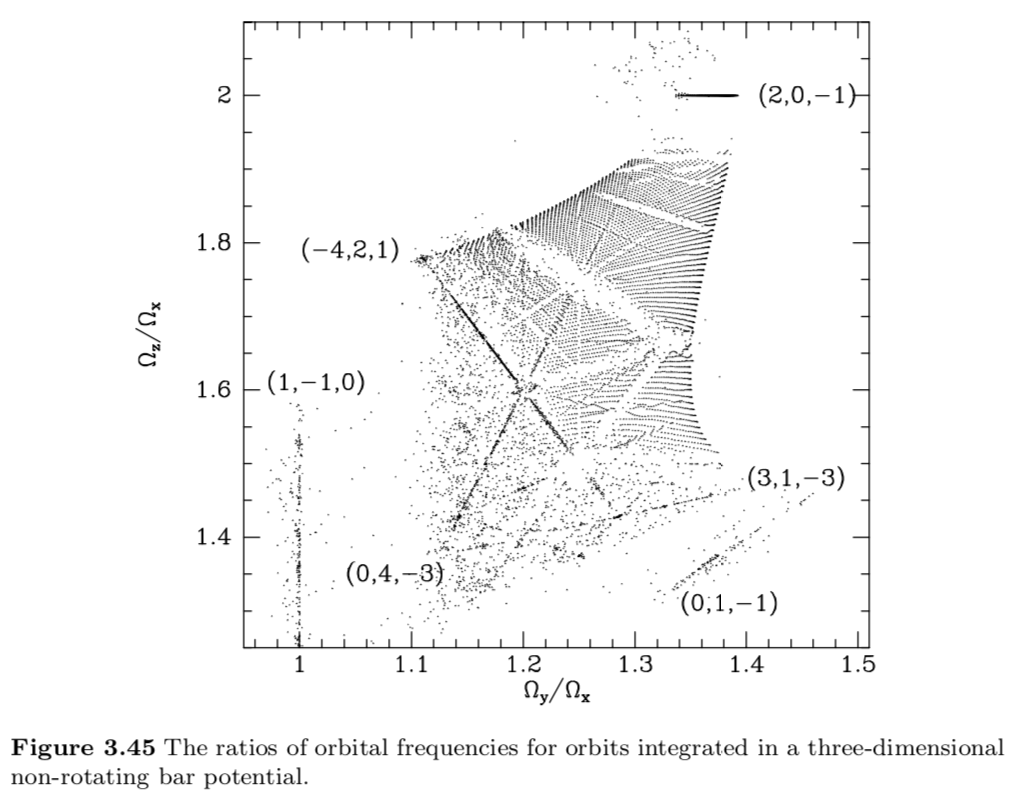

In [6]:
Image(filename='BTFig3.45.png', width=512) 

Our first goal for this tutorial is to reproduce something that looks like the above figure from Galactic Dynamics (pg. 260, Binney & Tremaine 2008; BT08). This figure shows fundamental frequency ratios computed from a bunch of orbits (each black point is an orbit) integrated in a particular gravitational potential, defined in equation 3.310:

$$
\Phi(\boldsymbol{x}) = \frac{1}{2} \, \ln \left[x^2 + (y/0.9)^2 + (z/0.7)^2 + 0.1\right]
$$

To produce this figure, we have to first set up a grid of orbital initial conditions similar to how it is done in BT08, then numerically integrate each orbit for some amount of time, and finally use the orbital trajectories to estimate the fundamental frequencies. 

### Defining the gravitational potential

Let's start by creating a Python object to represent the above graviational potential. Many common analytic potential models are implemented in `gala.potential` and make use of unit systems through the `astropy.units` framework. Here, however, the potential is dimensionless, so we will define the potential object using the numbers specified in Eq. 3.310 with no associated units. The potential specified above is a particular instance of a more general class of logarithmic potentials. These are often parametrized more generally as:

$$
\Phi(\boldsymbol{x}) = \frac{1}{2} \, v_c^2 \, \ln \left[(x/q_1)^2 + (y/q_2)^2 + (z/q_3)^2 + r_h^2\right]
$$

This general form is implemented in `gala` as the `gala.potential.LogarithmicPotential` class. Note that have imported `gala.potential` as `gp` above, so you will often see this shorthand below. By comparing the general form to Eq. 3.310, we can see that here we want: $v_c = 1$, $q_1 = 1$, $q_2 = 0.9$, $q_3 = 0.7$, and $r_h = \sqrt{0.1}$. Let's use these values to define the potential object:

In [7]:
pot = gp.LogarithmicPotential(v_c=1, r_h=np.sqrt(0.1), q1=1, q2=0.9, q3=0.7)

Each potential class or model that is implemented in `gala` has the same functionality that may help you with your work - see the [gala.potential documentation](http://gala.adrian.pw/en/latest/potential/index.html) for more details. Some important highlights:
* Each potential object has three core methods: `.energy()`, `.gradient()`, and `.density()`. `energy()` computes the potential energy at a specified location, `gradient()` computes the (Cartesian) gradient of the potential at a specified location, and `density()` compute the corresponding density of the mass distribution that generates the potential (for potentials with corresponding densities - not all potentials have well-defined density functions, such as the one we are using, the logarithmic potential). 
* Some other, potentially useful methods are `.mass_enclosed()` and `.circular_velocity()`, which return approximations to the enclosed mass and circular velocity at the specified location.
* There are also methods for plotting 2D projected isopotential and isodensity contours using the `.plot_contours()` and `.plot_density_contours()` methods, but we won't cover those today.

In [139]:
pot_val = 0.5

### Setting up the initial conditions

BT08 describes their method for creating initial conditions as: "10 000 orbits were obtained by dropping particles from a grid of points on the surface Φ(x) = 0.5". This doesn't fully specify how we should

In [140]:
def f1(x):
    return pot.energy([x[0], 0, 0])[0] - pot_val

def f2(y, x):
    return pot.energy([x, y, 0])[0] - pot_val

def f3(z, x, y):
    return pot.energy([x, y, z])[0] - pot_val

In [218]:
n_orbits_x = 50
n_orbits_y = 50

x_max, = fsolve(f1, x0=[0.5])
all_x = np.linspace(0.01, x_max, n_orbits_x)

xyz = []
for x in tqdm(all_x):
    y_max, = fsolve(f2, x0=[0.5], args=(x, ))
    all_y = np.linspace(0., y_max, n_orbits_y)
    
    for y in all_y:
        z, = fsolve(f3, x0=[0.5], args=(x, y))
        xyz.append([x, y, z])
        assert np.isclose(pot.energy([x, y, z])[0], pot_val)

xyz = np.array(xyz).T
n_orbits = xyz.shape[1]

# n_orbits = 1000
# xyz = np.zeros((3, n_orbits))

# for i in trange(n_orbits):
#     x_max, = fsolve(f1, x0=[0.5])
#     x = np.random.uniform(0, x_max)

#     y_max, = fsolve(f2, x0=[0.5], args=(x, ))
#     y = np.random.uniform(0, y_max)

#     z, = fsolve(f3, x0=[0.5], args=(x, y))

#     assert np.isclose(pot.energy([x, y, z])[0], pot_val)
#     xyz[:, i] = [x, y, z]

100%|██████████| 50/50 [00:02<00:00, 17.76it/s]


In [219]:
w0 = gd.PhaseSpacePosition(pos=xyz, 
                           vel=np.zeros_like(xyz))

In [220]:
orbits = pot.integrate_orbit(w0, dt=0.2, n_steps=2000, 
                             Integrator=gi.DOPRI853Integrator)

In [221]:
superfreq = sf.SuperFreq(t=orbits.t.value, p=4)

In [222]:
all_freqs = []
n_fail = 0
for j in trange(n_orbits):
    fs = [orbits[:, j].xyz[i] + 1j*orbits[:, j].v_xyz[i] for i in range(3)]
    try:
        freqs, *_ = superfreq.find_fundamental_frequencies(fs)
    except (RuntimeError, IndexError):
        freqs = np.full(3, np.nan)
        n_fail += 1
    all_freqs.append(freqs)
all_freqs = np.array(all_freqs)

print("{} failed".format(n_fail))

100%|██████████| 2500/2500 [02:49<00:00, 14.71it/s]

141 failed


Text(0, 0.5, '$\\Omega_z / \\Omega_x$')

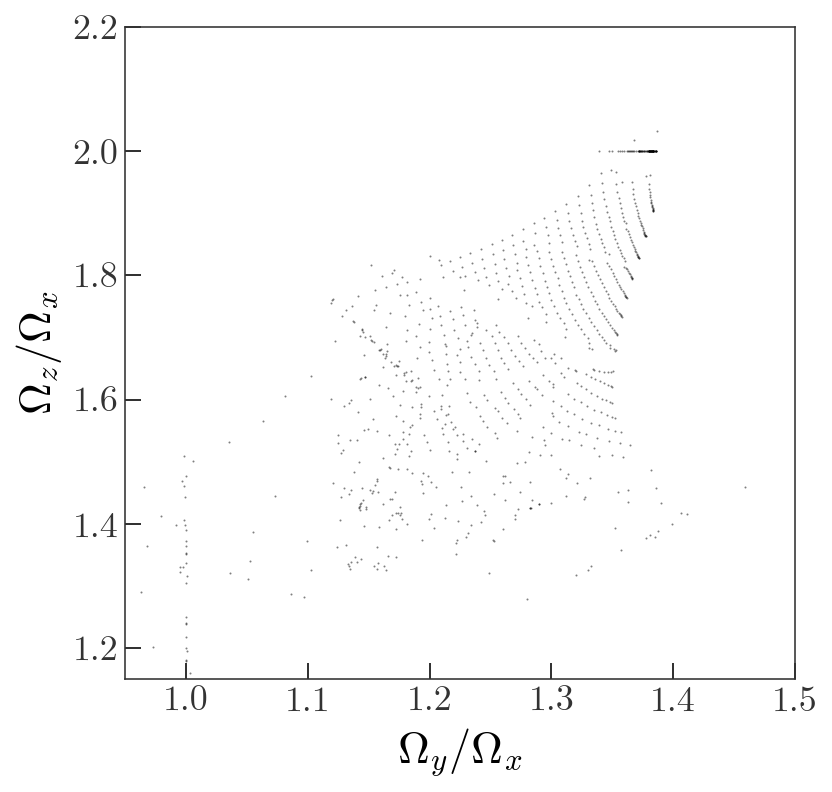

In [217]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

ax.scatter(all_freqs[:, 1] / all_freqs[:, 0],
           all_freqs[:, 2] / all_freqs[:, 0],
           marker='o', s=1., color='k', alpha=0.5, lw=0)

ax.set_xlim(0.95, 1.5)
ax.set_ylim(1.15, 2.2)

ax.set_xlabel(r'$\Omega_y / \Omega_x$')
ax.set_ylabel(r'$\Omega_z / \Omega_x$')